In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
import re
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score
from scikitplot.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/kaggle/input/chat-sentiment-dataset/chat_dataset.csv


**Data Load**

In [2]:
df=pd.read_csv("/kaggle/input/chat-sentiment-dataset/chat_dataset.csv", header=0, index_col=False)

In [3]:
df 

,message,sentiment
0,I really enjoyed the movie,positive
1,The food was terrible,negative
2,I'm not sure how I feel about this,neutral
3,The service was excellent,positive
4,I had a bad experience,negative
...,...,...
579,I have to cancel my vacation plans because I c...,negative
580,My computer crashed and I lost all my importan...,negative
581,I got into a car accident and my car is totale...,negative
582,I have a cold and can't stop coughing. it's re...,negative


In [4]:
df.shape

(584, 2)

<AxesSubplot:xlabel='sentiment', ylabel='count'>

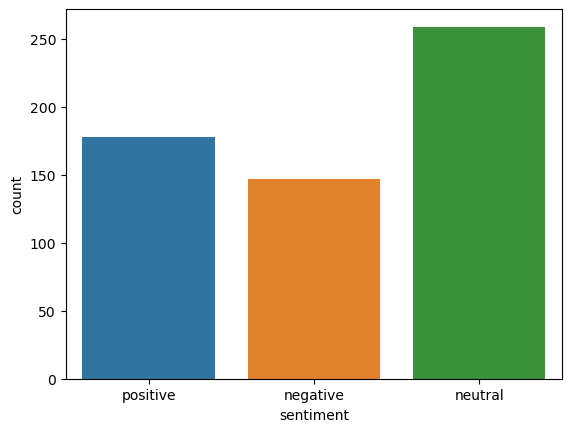

In [5]:
sns.countplot(x='sentiment',data=df)

Text(0.5, 1.0, 'proportion of sentiment')

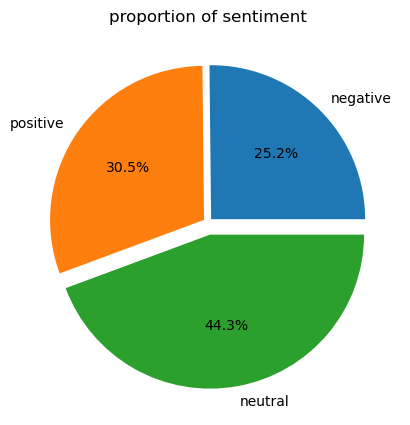

In [6]:
x=df.sentiment.value_counts().sort_values()
plt.figure(figsize=(5,5))
plt.pie(x=x,labels=x.index,autopct = '%1.1f%%', explode = [0.03, 0.03, 0.08])
plt.title("proportion of sentiment")


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


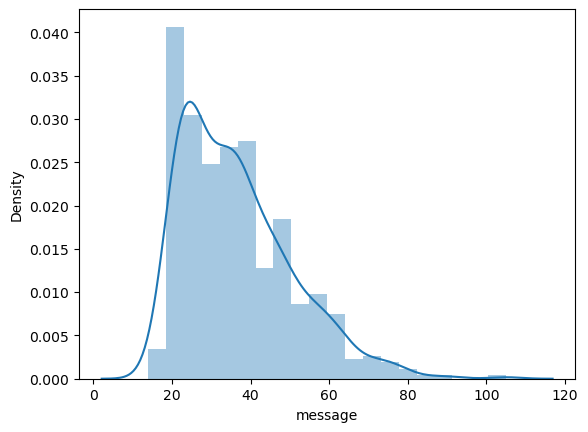

In [7]:
sns.distplot(df.message.str.len())

plt.show()

In [8]:
df.message.str.len().describe()

count    584.000000
mean      36.494863
std       14.130486
min       14.000000
25%       25.000000
50%       34.000000
75%       45.000000
max      105.000000
Name: message, dtype: float64

In [9]:
print(df.message.str.split(),'\n')

0                       [I, really, enjoyed, the, movie]
1                             [The, food, was, terrible]
2            [I'm, not, sure, how, I, feel, about, this]
3                         [The, service, was, excellent]
4                           [I, had, a, bad, experience]
                             ...                        
579    [I, have, to, cancel, my, vacation, plans, bec...
580    [My, computer, crashed, and, I, lost, all, my,...
581    [I, got, into, a, car, accident, and, my, car,...
582    [I, have, a, cold, and, can't, stop, coughing....
583    [I, just, found, out, my, ex, is, dating, some...
Name: message, Length: 584, dtype: object 



In [10]:
lm=WordNetLemmatizer()
def clean_data(data):
    empty=[]
    for row in data:
        new_row=re.sub('[^a-zA-Z]',' ', str(row))
        new_row=new_row.lower()
        new_row=word_tokenize(new_row)
        new_row=[word for word in new_row if word not in set(stopwords.words('english'))]
        empty.append(' '.join(str(x) for x in new_row))
    return empty
    


In [11]:
empty=clean_data(df['message'])

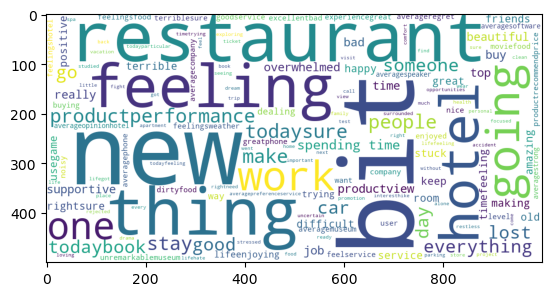

In [12]:
word_cloud=" "
for row in empty:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)
        

In [13]:
df['message']

0                             I really enjoyed the movie
1                                  The food was terrible
2                     I'm not sure how I feel about this
3                              The service was excellent
4                                 I had a bad experience
                             ...                        
579    I have to cancel my vacation plans because I c...
580    My computer crashed and I lost all my importan...
581    I got into a car accident and my car is totale...
582    I have a cold and can't stop coughing. it's re...
583    I just found out my ex is dating someone new. ...
Name: message, Length: 584, dtype: object

In [14]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(empty)

In [15]:
X=traindata
y=df['sentiment']
from sklearn.model_selection import train_test_split,StratifiedKFold
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

In [16]:
parameters= {'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
'penalty' : ['l2'],
'C' : [100, 10, 1.0, 0.1, 0.01]}

In [17]:
model=LogisticRegression()
grid=GridSearchCV(model,parameters,cv=5,return_train_score=True,n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             return_train_score=True)

In [18]:
grid.best_estimator_

LogisticRegression(C=100, solver='newton-cg')

In [19]:
pred=grid.predict(X_test)

In [20]:
accuracy_score(y_test,pred)

0.7670454545454546

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

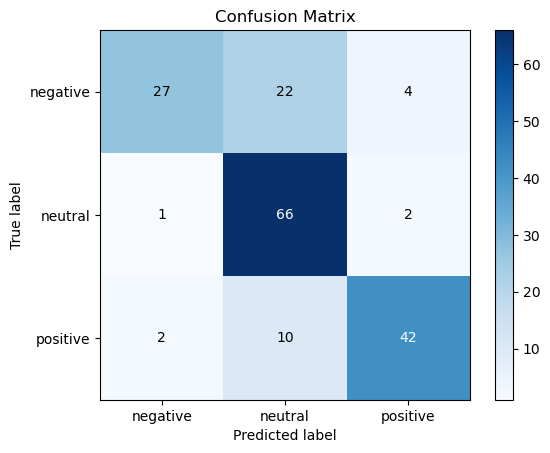

In [21]:
plot_confusion_matrix(y_test,pred)